# Comparing Branch Stability

This notebook aims to answer an overaching questions describing FLASC's behaviour:

1. How does FLASC's branch-detection ability compare to kMeans (and HDBSCAN\*) in
   terms of accuracy and stability?

To answer this question, we compare the algorithms on a synthetic dataset for
which we have ground-truth branch-membership information. To make the comparison
fair(ish), we first search for optimal parameter settings. Then, we compare the
algorithms using the adjusted rand index (ARI) between the ground-truth and
their detected subgroups. ARI measures how well the algorithms segmented the
points into the true branch-based subgroups. Finally, we compare the algorithms'
stability by measuring how much the detected sub-group centroids move between
repeated runs.

## Setup
Load libraries used:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

from scipy import linalg
from sklearn.utils import shuffle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import pairwise_distances

from flasc import FLASC
from flasc.prediction import branch_centrality_vectors, update_labels_with_branch_centrality, branch_membership_from_centrality
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans

## Datasets

For this comparison to work, we will use datasets with (known) branches that are
not detectable as a density-based cluster. Specifically, we use 2D datasets with
a single cluster containing three branches arranged in a three-point star. Data
points are placed along the branches logarithmically, with the densest regions
at the center of the cluster. This construction avoids placing a local density
maximum in the branches, intentionally making it difficult for HDBSCAN\* to
detect them!

In [3]:
def make_dataset(num_samples=100, length=2, scale=0.02):
    """Creates a dataset with three branches.

    Datapoints are spaced logarithmically along the branch length,
    with the high-density part at the ends of the branches.
    """

    def rotation(axis=[0, 0, 1], theta=0):
        return linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * theta))

    def rotate(X, axis=[0, 0, 1], theta=0):
        M = rotation(axis=axis, theta=theta)
        data = np.hstack((X, np.zeros((X.shape[0], 1), dtype=X.dtype)))
        return (M @ data.T).T[:, :2]

    max_exp = np.log(length)
    x = np.exp(np.linspace(0, max_exp, num_samples)) - 1
    branch = np.hstack((x[None].T, np.zeros((x.shape[0], 1), dtype=x.dtype)))
    X = np.vstack(
        (
            rotate(branch, theta=np.pi / 2),
            rotate(branch, theta=2 * np.pi / 3 + np.pi / 2),
            rotate(branch, theta=4 * np.pi / 3 + np.pi / 2),
        )
    )
    X += np.random.normal(scale=scale, size=X.shape)
    y = np.repeat([0, 1, 2], num_samples)
    X, y = shuffle(X, y)
    return X, y


def _centroid(X, y):
    """Computes ground-truth average positions."""
    return np.vstack([np.average(X[y == i, :], axis=0) for i in range(3)])

The datasets are parameterized by two values: the branch length and noise ratio.
Here, the branch length ($b_l$) controls the difference in density between the
cluster's center and the branches' ends. The noise ratio $n_r$ controls
the standard deviation $\sigma$ of Gaussian noise applied to the data points: 
$$
    n_r = \frac{4 \sigma}{\sqrt{\frac{1}{2}} b_l},
$$
Practically, $\pm 90\%$ of points move less than $n_r b_l$ 
away from their original point after noise is applied. 

Both parameters are varied to explore a wide range of datasets with this 
branching pattern.

In [4]:
np.unique(np.round(np.exp(np.linspace(np.log(2), np.log(100), 10))))[-5], (np.exp(np.linspace(0, np.log(2), 10)) - 1)[-5]

(18.0, 0.4697344922755988)

In [5]:
# Dataset parameters
lengths = np.unique(np.round(np.exp(np.linspace(np.log(2), np.log(100), 10))))
ratios = (np.exp(np.linspace(0, np.log(2), 10)) - 1)
repeats = np.arange(10)

datasets = pd.DataFrame([
        x for x in itertools.product(
            repeats, 
            ratios,
            lengths, 
        )
    ], columns=[
        'repeat', 'noise_ratio', 'branch_length'
    ]
)
samples = tuple(zip(*[
    make_dataset(
        length=datasets.branch_length[i], 
        scale=(datasets.branch_length[i] * datasets.noise_ratio[i]) / 4 * np.sqrt(1/2)
    )
    for i in range(datasets.shape[0])
]))
datasets['X'] = list(samples[0])
datasets['y'] = list(samples[1])
datasets['centroids'] = [ 
    _centroid(datasets.X[i], datasets.y[i]) for i in range(datasets.shape[0])
]
datasets.branch_length = datasets.branch_length.apply(int)
datasets.to_pickle('./data/generated/branch_stability_data.pickle')

## Parameter Sweeps

### FLASC

First, we analyze FLASC's performance on the datasets. We set several
parameters to fixed values to ensure a single cluster is detected. Unlike 
HDBSCAN\*, FLASC will give all points the 0-label when a single cluster 
is detected.

In [6]:
# Fixed parameters
kwargs = {
    'min_samples': 5,
    'min_cluster_size': 25,
    'allow_single_cluster': True
}

Other parameters are varied, to analyze FLASC's stability and parameter
sensitivity. We store flasc's final labelling for each combination of 
parameter values.

In [7]:
# Algorithm parameters
min_branch_size = np.arange(2, 25, 2)
branch_selection_method = ['eom', 'leaf']
branch_detection_method = ['full', 'core']
params = pd.DataFrame([
    x for x in itertools.product(
        repeats, ratios, lengths, min_branch_size,
        branch_detection_method, branch_selection_method
    )
], columns=[
    'repeat', 'noise_ratio', 'branch_length', 
    'min_branch_size', 'branch_detection_method',
    'branch_selection_method'
]
)
params['algorithm'] = ['FLASC' for _ in range(params.shape[0])]
params.branch_length = params.branch_length.apply(int)

The cell below actually runs FLASC on the dataset and prepares for
two metrics on the resulting labelling: (1) the adjusted rand index, 
a metric indicating how well FLASC's labelling reflects the ground truth, and
(2) the centroid spread, a metric indicating how varied FLASC's labelling is
across the different samples with the same parameters. Both metrics will be 
explained in more detail below.

Running this cell takes about 20 minutes.

In [8]:
def run_setting(p):
    """Runs flasc on a dataset."""
    # Extract Dataset properties
    subset = datasets[
        (datasets.repeat == p["repeat"])
        & (datasets.noise_ratio == p.noise_ratio)
        & (datasets.branch_length == p.branch_length)
    ].iloc[0]
    X = subset.X
    y = subset.y
    truth = subset.centroids

    # Run flasc
    c = FLASC(
        min_branch_size=p.min_branch_size,
        branch_detection_method=p.branch_detection_method,
        branch_selection_method=p.branch_selection_method,
        **kwargs,
    ).fit(X)

    # Compute geodesic membership & probabilities
    centrality_vectors = branch_centrality_vectors(c)
    labels, branch_labels = update_labels_with_branch_centrality(c, centrality_vectors)

    # Compute ARI
    ari = adjusted_rand_score(labels, y)

    # Compute centroids
    centroids = []
    num_labels = len(np.unique(labels)) - int(-1 in labels)
    for l in range(num_labels):
        mask = labels == l
        centroids.append(np.average(X[mask, :], weights=c.probabilities_[mask], axis=0))

    # Assign centroids to ground-truth centroids
    dists = pairwise_distances(centroids, truth)
    order = np.argmin(dists, axis=1)

    # Return everything
    return (labels, c.probabilities_, centroids, order, ari, num_labels)


(
    params["labels"],
    params["probabilities"],
    params["centroids"],
    params["true_labels"],
    params["ari"],
    params["num_labels"],
) = zip(*[run_setting(params.iloc[i]) for i in trange(params.shape[0])])
params.to_pickle("./data/generated/branch_stability_labelling_flasc.pickle")

  0%|          | 0/48000 [00:00<?, ?it/s]

100%|██████████| 48000/48000 [05:23<00:00, 148.45it/s]


### HDBSCAN\*

Second, we analyze HDBSCAN\* performance on the dataset. The *min_samples* 
parameter is fixed to the same value as used by FLASC

In [9]:
# Fixed parameters
kwargs = {
    'min_samples': int(5),
}

Other parameters are varied to find the best-performing setting, giving HDBSCAN\*
a fair chance to find the branch-subgroups.

In [10]:
# Algorithm parameters
min_cluster_size = np.arange(2, 25, 2)
cluster_selection_method = ['eom', 'leaf']
params = pd.DataFrame([
    x for x in itertools.product(
        repeats, ratios, lengths, min_cluster_size,
        cluster_selection_method,
    )
], columns=[
    'repeat', 'noise_ratio', 'branch_length', 
    'min_cluster_size', 'cluster_selection_method'
])
params['algorithm'] = ['HDBSCAN\*' for _ in range(params.shape[0])]
params.branch_length = params.branch_length.apply(int)

The cell below actually evaluates HDBSCAN\* and computes the adjusted rand index metric in about 10 minutes!

In [11]:
def run_setting(p):
    # Extract dataset
    subset = datasets\
        .query(f'repeat == {p["repeat"]}')\
        .query(f'noise_ratio == {p.noise_ratio}')\
        .query(f'branch_length == {p.branch_length}').iloc[0]
    X = subset.X
    y = subset.y

    # Run HDBSCAN
    c = HDBSCAN(
        min_cluster_size=int(p.min_cluster_size),
        cluster_selection_method=p.cluster_selection_method,
        **kwargs
    ).fit(X)
    
    # Compute ARI
    ari = adjusted_rand_score(c.labels_, y)
    num_labels = len(np.unique(c.labels_)) - int(-1 in c.labels_)
    return (
        c.labels_, c.probabilities_, ari, num_labels
    )

(
    params['labels'], 
    params['probabilities'],
    params['ari'],
    params['num_labels']
) = zip(*[
    run_setting(params.iloc[i]) for i in trange(params.shape[0])
])
params.to_pickle('./data/generated/branch_stability_labelling_hdbscan.pickle')

  0%|          | 0/24000 [00:00<?, ?it/s]

100%|██████████| 24000/24000 [01:46<00:00, 226.22it/s]


### k-Means

Finally, we run kMeans on this dataset with $k=3$ as optimal value.

In [12]:
# Fixed parameters
kwargs = {
    'n_clusters': int(3),
}

kMeans does not have other parameters to tune.

In [13]:
# Algorithm parameters
params = pd.DataFrame(
    [x for x in itertools.product(repeats, ratios, lengths)],
    columns=["repeat", "noise_ratio", "branch_length"],
)
params["algorithm"] = "kMeans"
params.branch_length = params.branch_length.apply(int)

The cell below actually evaluates kMeans and computes the adjusted rand index metric in about x minutes!

In [ ]:
def run_setting(p):
    # Extract dataset
    subset = (
        datasets.query(f'repeat == {p["repeat"]}')
        .query(f"noise_ratio == {p.noise_ratio}")
        .query(f"branch_length == {p.branch_length}")
        .iloc[0]
    )
    X = subset.X
    y = subset.y
    truth = subset.centroids

    # Run HDBSCAN
    c = KMeans(**kwargs).fit(X)

    # Compute ARI
    ari = adjusted_rand_score(c.labels_, y)
    num_labels = len(np.unique(c.labels_)) - int(-1 in c.labels_)

    # Compute centroids
    centroids = []
    num_labels = len(np.unique(c.labels_)) - int(-1 in c.labels_)
    for l in range(num_labels):
        mask = c.labels_ == l
        centroids.append(np.average(X[mask, :], axis=0))

    # Assign centroids to ground-truth centroids
    dists = pairwise_distances(centroids, truth)
    order = np.argmin(dists, axis=1)

    return (c.labels_, centroids, order, ari, num_labels)


(
    params["labels"],
    params["centroids"],
    params["true_labels"],
    params["ari"],
    params["num_labels"],
) = zip(*[run_setting(params.iloc[i]) for i in trange(params.shape[0])])
params.to_pickle("./data/generated/branch_stability_labelling_kmeans.pickle")

## Results


First, we read in the data files so previous runs can be re-plotted and specify 
human readable names for the columns. Names with an underscore result in an error 
because Latex is used to render text in the images. To disable this, edit
`./notebooks/_plotting.py`!

In [15]:
datasets = pd.read_pickle('./data/generated/branch_stability_data.pickle')
fparams = pd.read_pickle('./data/generated/branch_stability_labelling_flasc.pickle')
hparams = pd.read_pickle('./data/generated/branch_stability_labelling_hdbscan.pickle')
mparams = pd.read_pickle('./data/generated/branch_stability_labelling_kmeans.pickle')
ratios = datasets.noise_ratio.unique()
lengths = datasets.branch_length.unique()

In [16]:
display_names = {
    'columns': {
        'branch_length': 'Branch length',
        'num_clusters': 'Num clusters',
        'num_labels': 'Num labels',
        'num_branches': 'Num branches',
        'noise_ratio': 'Noise ratio',
        'min_branch_size': 'Min branch size',
        'min_cluster_size': 'Min cluster size',
        'branch_detection_method': 'Graph',
        'branch_selection_method': 'Selection',
        'cluster_selection_method': 'Selection',
        'ari': 'ARI',
        'algorithm': 'Algorithm',
        'centroid_spread': 'Centroid spread'
    }
}

### Computing Centroid Spread

First, we try to find out for which parameter settings the algorithms perform
best on this dataset before we compare the algorithms to each other. For this
purpose we use two metrics, the *adjusted rand index* and *centroid spread*.

The *adjusted rand index* (ARI) is a quality measure for clustering algorithms.
I interpret it as using the clustering as classifier and computing how well data
points of the same class are put into the same cluster. We use this metric to
determine which parameter settings work best.

The *centroid spread*  measures how much the subgroups' weighted average vary
between datasets generated with the same parameters. It measures how stable
FLASC's output is. The spread is expressed in terms of branch length $b_l$ to be
able to compare the different datasets. Specifically. it is calculated by:
- Computing the ground-truth branch average (unweighted)
- Computing the detected subgroup averages (weighted) (= centroid)
- Assigning each centroid to the closest ground-truth centroid on that dataset.
- Computing the average centroid coordinates (unweighted) for all centroids
  assigned to the same ground-truth centroid of datasets with the same branch
  length and noise ratio. (= root)
- Computing the distance of each centroid to their root in terms of branch
  length $b_l$. The 50 and 95 percentile distance are used to quantify and
  visualize the centroid spread.

In [17]:
def _centroid_spread(p):
    # Compute root
    root = [
        np.average(p.centroids[p.true_labels == k, :], axis=0) 
        if np.sum(p.true_labels == k) > 0 else None 
        for k in range(3)
    ]
    # Subtract roots from centroids and scale by branch length
    offsets = np.asarray([root[k] for k in p.true_labels])
    centralized = (p.centroids - offsets) / p.branch_length
    # Compute spread
    spread = pairwise_distances(np.asarray([[0, 0]]), centralized)[0,:]
    return centralized, np.asarray(root), spread
    

# FLASC: Merge repeats into single column and compute spread
fgrouped = fparams.groupby(by=[
    'branch_length', 'noise_ratio', 'min_branch_size', 
    'branch_detection_method','branch_selection_method'
]).agg(
    centroids=pd.NamedAgg(column="centroids", aggfunc=lambda x: np.concatenate(list(x))),
    true_labels=pd.NamedAgg(column="true_labels", aggfunc=lambda x: np.concatenate(list(x))),
).reset_index()
(fgrouped['centralized_centroids'], fgrouped['roots'], fgrouped['centroid_spread']) = zip(*[
    _centroid_spread(fgrouped.iloc[i]) for i in trange(fgrouped.shape[0])
]) 

# kMeans: Merge repeats into single column and compute spread
kgrouped = fparams.groupby(by=[
    'branch_length', 'noise_ratio'
]).agg(
    centroids=pd.NamedAgg(column="centroids", aggfunc=lambda x: np.concatenate(list(x))),
    true_labels=pd.NamedAgg(column="true_labels", aggfunc=lambda x: np.concatenate(list(x))),
).reset_index()

# Compute roots and spread
(kgrouped['centralized_centroids'], kgrouped['roots'], kgrouped['centroid_spread']) = zip(*[
    _centroid_spread(kgrouped.iloc[i]) for i in trange(kgrouped.shape[0])
]) 

  0%|          | 0/4800 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1999.98it/s]


The figures illustrate how the centroid spread is computed:

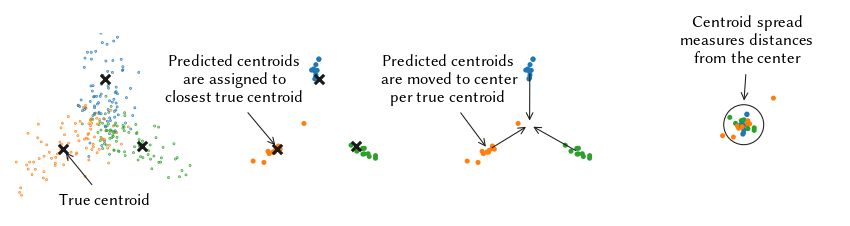

In [20]:
# Pick a dataset setting
r = ratios[-5]
l = lengths[-5]        

# Extract dataset properties
s = datasets\
    .query(f'repeat == 4')\
    .query(f'noise_ratio == {r}')\
    .query(f'branch_length == {l}').iloc[0]
X = s.X
y = s.y
truths = s.centroids

# Extract FLASC properties
s = fgrouped.query(
    f'noise_ratio == {r} & '
    f'branch_length == {l} & '
    'min_branch_size == 12 &  '
    'branch_detection_method == "core" & '
    'branch_selection_method=="leaf"'
).iloc[0]
centroids = s.centroids
labels = s.true_labels
roots = s.roots

# Create figure
sized_fig(1, 1 / 4)

plt.subplot(1, 4, 1)
plt.scatter(X.T[0], X.T[1], 0.1, y, cmap='tab10', vmax=10, label='point')
plt.scatter(truths.T[0], truths.T[1], 20, color='k', marker='x', label='true centriod')
frame_off()
lims = [0.6 * l for l in plt.xlim()]
plt.xlim(lims)
plt.ylim(lims)
plt.annotate(
    'True centroid', 
    xytext=(np.median(truths.T[0]), np.percentile(X.T[1], 2)), 
    xy=truths[1, :], 
    fontsize=8, 
    ha='center', 
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', linewidth=0.5)
)

plt.subplot(1, 4, 2)
plt.scatter(centroids.T[0], centroids.T[1], 2, labels, cmap='tab10', vmax=10, label='found centroid')
plt.scatter(truths.T[0], truths.T[1], 20, color='k', marker='x', label='true centriod')
frame_off()
plt.xlim(lims)
plt.ylim(lims)
plt.text(
    s='Predicted centroids', 
    x=np.percentile(X.T[0], 5),
    y=np.percentile(X.T[1], 90), 
    fontsize=8, 
    ha='center', 
    va='center',
)
plt.text(
    s='are assigned to', 
    x=np.percentile(X.T[0], 5),
    y=np.percentile(X.T[1], 90) - 2, 
    fontsize=8, 
    ha='center', 
    va='center',
)
plt.annotate(
    'closest true centroid', 
    xytext=(np.percentile(X.T[0], 5), np.percentile(X.T[1], 90)-4), 
    xy=centroids[13, :], 
    fontsize=8, 
    ha='center', 
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', linewidth=0.5)
)

plt.subplot(1, 4, 3)
for r in roots:
    plt.gca().annotate("", xy=(0, 0), xytext=r,
                       arrowprops=dict(arrowstyle="->", color='k', linewidth=0.5))
plt.scatter(centroids.T[0], centroids.T[1], 2, labels, cmap='tab10', vmax=10, label='found centroid')
frame_off()
plt.xlim(lims)
plt.ylim(lims)
plt.text(
    s='Predicted centroids', 
    x=np.percentile(X.T[0], 5),
    y=np.percentile(X.T[1], 90), 
    fontsize=8, 
    ha='center', 
    va='center',
)
plt.text(
    s='are moved to center', 
    x=np.percentile(X.T[0], 5),
    y=np.percentile(X.T[1], 90) - 2, 
    fontsize=8, 
    ha='center', 
    va='center',
)
plt.annotate(
    'per true centroid', 
    xytext=(np.percentile(X.T[0], 5), np.percentile(X.T[1], 90)-4), 
    xy=roots[1, :], 
    fontsize=8, 
    ha='center', 
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', linewidth=0.5)
)

plt.subplot(1, 4, 4)
centered = centroids - roots[labels]
radius = np.percentile(pairwise_distances(np.asarray([[0, 0]]), centered), 95)
circle = plt.Circle((0, 0), 
    radius=radius, 
    fill=False, 
    color='k',
    linewidth=0.5)
plt.gca().add_patch(circle)
plt.scatter(centered.T[0], centered.T[1], 2, labels, cmap='tab10', vmax=10, label='found centroid')
frame_off()
plt.xlim(lims)
plt.ylim(lims)
plt.text(
    s='Centroid spread', 
    x=np.percentile(X.T[0], 50),
    y=np.percentile(X.T[1], 95), 
    fontsize=8, 
    ha='center', 
    va='center',
)
plt.text(
    s='measures distances', 
    x=np.percentile(X.T[0], 50),
    y=np.percentile(X.T[1], 95) - 2, 
    fontsize=8, 
    ha='center', 
    va='center',
)
plt.annotate(
    'from the center', 
    xytext=(np.percentile(X.T[0], 50), np.percentile(X.T[1], 95)-4), 
    xy=(0, radius), 
    fontsize=8, 
    ha='center', 
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', linewidth=0.5)
)

plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('./images/branch_stability_centroid_spread_explainer.png', dpi=600, pad_inches=0)
plt.show()

### Optimal parameters

In this section, we try to find out for which parameters the algorithms perform
best.

#### FLASC

In the figure below, the branch detection and branch selection combinations are
compared by their ARI value over the *min branch size* parameter. The selection
method does not appear to make much difference. The *core* detection method
performs best on this dataset. This is expected, because the center-subgroup,
detected by FLASC, is smaller in the *core* detection method than in the *full*
detection method. Most confusion of points happens in the center, so the larger
the center the lower the ARI! At lower *min branch size* values, the ARI value
decreases, probably because too many branches are detected with those settings.

If these values look low, remember that they are averaged over all branch lengths
and noise ratios! Also, the shaded areas show the 95\% confidence interval of the 
mean, not the standard deviation!!

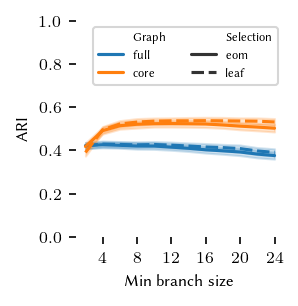

In [21]:
sized_fig(1/3, aspect=1)
sns.lineplot(
    fparams.rename(**display_names), 
    x='Min branch size', y='ARI', hue='Graph', 
    style='Selection', palette='tab10', hue_order=["full", "core"])
l = plt.legend(loc='best', ncol=2)
adjust_legend_subtitles(l)
plt.ylim([0, 1])
plt.xticks([4, 8, 12, 16, 20, 24])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylabel('ARI')
plt.subplots_adjust(0.23, 0.2, 0.99, .99)
plt.show()

The next figure compares the same variables on the centroid spread. Here,
lower values are better. Clearly the *core* detection method performs better, it 
has a lower cluster spread but is more sensitive to low *min branch size* values.

For comparing FLASC to HDBSCAN\* we will use the following settings:
- *min branch length* = 12
- *branch detection method* = *core*
- *branch selection method* = *leaf*

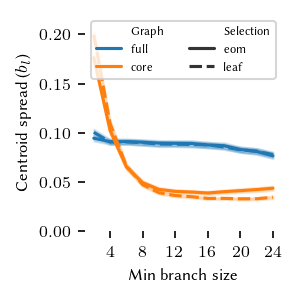

In [22]:
sized_fig(1/3, aspect=1)
sns.lineplot(
    fgrouped.explode('centroid_spread').rename(**display_names), 
    x='Min branch size', y='Centroid spread', hue='Graph', 
    style='Selection', palette='tab10', hue_order=["full", "core"]
)
l = plt.legend(loc='best', ncol=2)
adjust_legend_subtitles(l)
plt.ylim([0, 0.22])
plt.xticks([4, 8, 12, 16, 20, 24])
plt.ylabel('Centroid spread ($b_l$)')
plt.subplots_adjust(0.27, 0.2, 0.99, .99)
plt.show()

#### HDBSCAN\*
In this section, we try to find out for which parameters HDBSCAN\* performs
best.

In the figure below, HDBSCAN\*'s average ARI value is shown for the different
*cluster selection methods* over the *min cluster size* parameter. Although the
ARI values are low, there is a distinct peak at *min cluster size* = 8 with
*cluster selection method* = *leaf*. 

The conclusion here should basically be that we succeeded in generating groups
that are not detectable as density-based cluster!

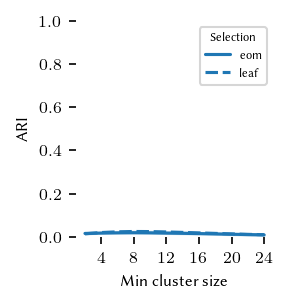

In [23]:
sized_fig(1/3, aspect=1)
sns.lineplot(
    hparams.rename(**display_names), 
    x='Min cluster size', y='ARI', style='Selection',
)
l = plt.legend(title='Selection', loc='best')
adjust_legend_subtitles(l)
plt.ylim([0, 1])
plt.xticks([4, 8, 12, 16, 20, 24])
# plt.yticks([0, 0.2, 0.4, 0.6])
plt.ylabel('ARI')
plt.subplots_adjust(0.27, 0.2, 0.99, .99)
plt.show()

### Visualize labeling

We show a selection of the labellings the algorithms created to understand how
they behave on this data. We'll use the optimal parameters identified previously
to get the best view of each algorithm. FLASC neatly separates points by their
branch but makes some 'errors' compared to the ground-truth in the center, where
points are not closest to the branch they belong to. kMeans also detects the
branches as subgroups, but puts the center in one branch. HDBSCAN\* does not
recover the branches as subgroups because there is no consistent density maximum
in the branches.

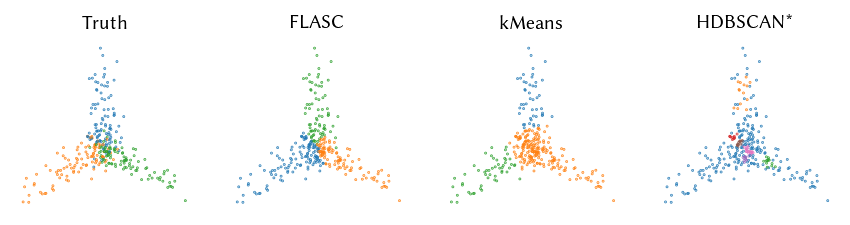

In [24]:
sized_fig(1, 1/4)

# Pick a dataset setting
r = ratios[-5]
l = lengths[-5]        

s = datasets\
    .query(f'noise_ratio == {r}')\
    .query(f'branch_length == {l}')

ks = mparams\
    .query(f'noise_ratio == {r}')\
    .query(f'branch_length == {l}')

fs = fparams\
    .query(f'noise_ratio == {r}')\
    .query(f'branch_length == {l}')\
    .query('branch_detection_method=="core"')\
    .query('branch_selection_method=="leaf"')\
    .query('min_branch_size==12')

hs = hparams\
    .query(f'noise_ratio == {r}')\
    .query(f'branch_length == {l}')\
    .query('cluster_selection_method=="leaf"')\
    .query('min_cluster_size==8')


for i, (alg, ys) in enumerate(zip(['Truth', 'FLASC', 'kMeans', 'HDBSCAN*'], [s.y, fs.labels, ks.labels, hs.labels])):
    plt.subplot(1, 4, i+1)
    X = s.X.iloc[4]
    y = ys.iloc[4]
    plt.scatter(X.T[0], X.T[1], 0.1, y, cmap='tab10', vmin=0, vmax=9)
    plt.title(alg, fontsize=9.5)
    frame_off()
plt.subplots_adjust(0, 0, 1, 0.9)
plt.savefig('./images/branch_stability_labelling_example.png', dpi=600, pad_inches=0)
plt.show()

### Branch detection quality

To investigate the quality of the branch segmentations, we investigate the average
ARI per *noise--length* combination.

For FLASC, we see high values at low noise levels, which decrease as the noise
increases. The longer the branches, the stronger the effect of noise. This
pattern can be explained by the behaviour of points in the centre. The longer
the branches, the more points there are in the center, which are the points that
get misclassified because they are closer to another branch's root.

kMeans shows a different pattern. Its ARI decreases with branch length and stays
stable acrross noise ratios.

HDBSCAN* is unable to detect the branches as subgroups (by design) and results
in very low ARI regardless of the setting. So we exclude it from the figure.

In [25]:
def draw_avg_heatmap(data, *args, **kwargs):
    d = data\
        .groupby([args[1], args[0]])[args[2]]\
        .mean()\
        .reset_index()\
        .pivot(index=args[1], columns=args[0], values=args[2])
    return sns.heatmap(d, **kwargs)

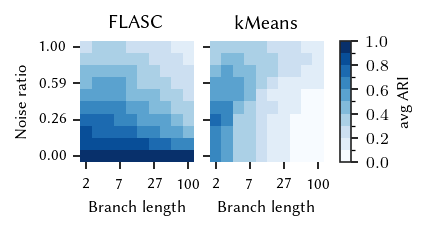

In [26]:
# Specify Colormap and ticks
bounds = np.linspace(0, 1, 11)
cmap = mpl.colormaps['Blues']
norm = BoundaryNorm(bounds, cmap.N)
yticks = [0.5, 3.5, 6.5, 9.5]
ytick_labels = [ f"{ratios[int(r)]:.2f}" for r in yticks ]
xticks = [0.5, 3.5, 6.5, 9.5]
xtick_labels = [ f"{int(lengths[int(r)]):d}" for r in xticks ]

sized_fig(1 / 2, 1 / 2)
fig = plt.gcf()
fig.subplots(1, 3, width_ratios=[1, 1, 0.1])

mset = mparams[['repeat','noise_ratio', 'branch_length', 'algorithm', 'ari']]
fset = fparams\
    .query('min_branch_size == 12 & branch_selection_method=="leaf" & branch_detection_method=="core"')\
    [['repeat','noise_ratio', 'branch_length', 'algorithm', 'ari']]


plt.subplot(1, 3, 1)
draw_avg_heatmap(
    fset.rename(**display_names),
    'Branch length', 'Noise ratio', 'ARI',
    cmap=cmap, norm=norm, cbar=False
)

plt.title('FLASC', fontsize=9.5)
plt.gca().invert_yaxis()
plt.yticks(yticks)
plt.xticks(xticks)
plt.gca().set_yticklabels(ytick_labels)
plt.gca().set_xticklabels(xtick_labels)

plt.subplot(1, 3, 2)
draw_avg_heatmap(
    mset.rename(**display_names),
    'Branch length', 'Noise ratio', 'ARI',
    cmap=cmap, norm=norm, cbar=False
)
plt.title('kMeans', fontsize=9.5)
plt.gca().invert_yaxis()
plt.yticks(yticks)
plt.xticks(xticks)
plt.ylabel('')
plt.gca().set_yticklabels(['' for _ in ytick_labels])
plt.gca().set_xticklabels(xtick_labels)

ax = plt.subplot(1, 3, 3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=ax, label='avg ARI')

plt.subplots_adjust(0.16, 0.27, 0.82, 0.86)
plt.savefig('./images/branch_stability_heatmap_avg_ari.png', dpi=600)
plt.show()

### Branch detection stability

An important aspect of a clustering algorithm is the stability. It should not
only accurately describe the underlying data's structure, it should also give
similar outputs on similar data set. In this section, we try to compare and
visualize this stability using the centroid spread.

The overall pattern is similar to the ARI heatmaps. For FLASC, The spread
increases with noise and that effect is stronger for larger branch lengths. For
kMeans, the centroid spread decreases with both the noise ratio and the branch
length, resulting in good performance only when both are low.

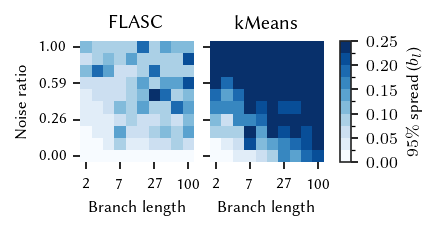

In [27]:
bounds = np.linspace(0, 1/4, 11)
norm = BoundaryNorm(bounds, cmap.N)
yticks = [0.5, 3.5, 6.5, 9.5]
ytick_labels = [ f"{ratios[int(r)]:.2f}" for r in yticks ]
xticks = [0.5, 3.5, 6.5, 9.5]
xtick_labels = [ f"{int(lengths[int(r)]):d}" for r in xticks ]

sized_fig(1 / 2, 1 / 2)
fig = plt.gcf()
fig.subplots(1, 3, width_ratios=[1, 1, 0.1])

kset = kgrouped\
    .groupby(['branch_length', 'noise_ratio']) \
    .agg(centroid_spread=pd.NamedAgg(
        column="centroid_spread", 
        aggfunc=lambda x: np.percentile(x.iloc[0], 95)
    )) \
    .reset_index() \
    .rename(**display_names)
fset = fgrouped\
        .query(
            'min_branch_size == 12 & '
            'branch_detection_method=="core" & '
            'branch_selection_method=="leaf"'
        )\
        .groupby(['branch_length', 'noise_ratio']) \
        .agg(centroid_spread=pd.NamedAgg(
            column="centroid_spread", 
            aggfunc=lambda x: np.percentile(x.iloc[0], 95)
        )) \
        .reset_index() \
        .rename(**display_names)

plt.subplot(1, 3, 1)
draw_avg_heatmap(
    fset, 'Branch length', 'Noise ratio', 'Centroid spread',
    cmap=cmap, norm=norm, cbar=False
)
plt.title('FLASC', fontsize=9.5)
plt.gca().invert_yaxis()

plt.yticks(yticks)
plt.xticks(xticks)
plt.gca().set_yticklabels(ytick_labels)
plt.gca().set_xticklabels(xtick_labels)

plt.subplot(1, 3, 2)
draw_avg_heatmap(
    kset, 'Branch length', 'Noise ratio', 'Centroid spread',
    cmap=cmap, norm=norm, cbar=False
)
plt.title('kMeans', fontsize=9.5)
plt.gca().invert_yaxis()
plt.yticks(yticks)
plt.xticks(xticks)
plt.ylabel('')
plt.gca().set_yticklabels(['' for _ in ytick_labels])
plt.gca().set_xticklabels(xtick_labels)

ax = plt.subplot(1, 3, 3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=ax, label='$95\%$ spread ($b_l$)')


# Adjust spacing and save
plt.subplots_adjust(0.16, 0.27, 0.82, 0.86)
plt.savefig('./images/branch_stability_heatmap_centroid_spread.png', dpi=600)
plt.show()